# - GoogleNet(inception v1)

https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K

In [2]:
img_dir = 'data/Images3'
categories = os.listdir(img_dir)
num_classes = len(categories)

In [3]:
image_w = 224
image_h = 224

In [4]:
X = []
y = []

for index, breed in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[index] = 1

    image_dir = img_dir + "/" + breed
    files = glob.glob(image_dir+"/*.jpg")
    print(index, ")", breed, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

0 ) n02085620-Chihuahua  파일 길이 :  152
1 ) n02085782-Japanese_spaniel  파일 길이 :  185
2 ) n02085936-Maltese_dog  파일 길이 :  252
3 ) n02086079-Pekinese  파일 길이 :  149
4 ) n02086240-Shih-Tzu  파일 길이 :  214
5 ) n02086646-Blenheim_spaniel  파일 길이 :  188
6 ) n02086910-papillon  파일 길이 :  196
7 ) n02088364-beagle  파일 길이 :  195
8 ) n02088466-bloodhound  파일 길이 :  187
9 ) n02089078-black-and-tan_coonhound  파일 길이 :  159
10 ) n02089867-Walker_hound  파일 길이 :  153
11 ) n02089973-English_foxhound  파일 길이 :  157
12 ) n02091032-Italian_greyhound  파일 길이 :  182
13 ) n02091134-whippet  파일 길이 :  187
14 ) n02093256-Staffordshire_bullterrier  파일 길이 :  155
15 ) n02093647-Bedlington_terrier  파일 길이 :  182
16 ) n02094258-Norwich_terrier  파일 길이 :  185
17 ) n02094433-Yorkshire_terrier  파일 길이 :  164
18 ) n02096294-Australian_terrier  파일 길이 :  196
19 ) n02096585-Boston_bull  파일 길이 :  182
20 ) n02097047-miniature_schnauzer  파일 길이 :  154
21 ) n02097209-standard_schnauzer  파일 길이 :  155
22 ) n02097658-silky_terrier  파일 길이 :  183

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
n = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(n)

In [7]:
X = X[n]
y = y[n]

In [8]:
print("Images shape after shuffling = ",X.shape,"\nLabels shape after shuffling = ",y.shape)

Images shape after shuffling =  (11418, 224, 224, 3) 
Labels shape after shuffling =  (11418, 65)


In [9]:
X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [11]:
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (8220, 224, 224, 3)
y_train shape =  (8220, 65)

x_val shape =  (914, 224, 224, 3)
y_val shape =  (914, 65)

x_test shape =  (2284, 224, 224, 3)
y_test shape =  (2284, 65)


In [12]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [13]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [14]:
input_layer = Input(shape=(image_w, image_h, 3))

x = Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu', name='conv_1_5x5/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=48,
                     filters_3x3=64,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=48,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=24,
                     filters_pool_proj=32,
                     name='inception_4a')


x1 = AveragePooling2D((3, 3), strides=3)(x)
x1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(num_classes, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=96,
                     filters_3x3_reduce=64,
                     filters_3x3=144,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')


x2 = AveragePooling2D((3, 3), strides=3)(x)
x2 = Conv2D(64, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(num_classes, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=80,
                     filters_3x3=160,
                     filters_5x5_reduce=24,
                     filters_5x5=96,
                     filters_pool_proj=96,
                     name='inception_4c')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=80,
                     filters_3x3=160,
                     filters_5x5_reduce=24,
                     filters_5x5=96,
                     filters_pool_proj=96,
                     name='inception_5')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(num_classes, activation='softmax', name='output')(x)

In [15]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_5x5/2 (Conv2D)           (None, 112, 112, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 32)   0           conv_1_5x5/2[0][0]               
__________________________________________________________________________________________________
conv_2_3x3/1 (Conv2D)           (None, 56, 56, 64)   18496       max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [16]:
model.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.001)

In [17]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
257/257 [==============================] - 303s 1s/step - loss: 12.5585 - output_loss: 4.2066 - auxilliary_output_1_loss: 4.1753 - auxilliary_output_2_loss: 4.1766 - output_accuracy: 0.0168 - auxilliary_output_1_accuracy: 0.0196 - auxilliary_output_2_accuracy: 0.0180 - val_loss: 12.5148 - val_output_loss: 4.1767 - val_auxilliary_output_1_loss: 4.1691 - val_auxilliary_output_2_loss: 4.1690 - val_output_accuracy: 0.0164 - val_auxilliary_output_1_accuracy: 0.0153 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 2/100
257/257 [==============================] - 302s 1s/step - loss: 12.5111 - output_loss: 4.1758 - auxilliary_output_1_loss: 4.1675 - auxilliary_output_2_loss: 4.1679 - output_accuracy: 0.0200 - auxilliary_output_1_accuracy: 0.0223 - auxilliary_output_2_accuracy: 0.0220 - val_loss: 12.5065 - val_output_loss: 4.1707 - val_auxilliary_output_1_loss: 4.1679 - val_auxilliary_output_2_loss: 4.1678 - val_output_accuracy: 0.0175 - val_auxilliary_output_1_accuracy: 0.0153 - v

Epoch 17/100
257/257 [==============================] - 298s 1s/step - loss: 12.4967 - output_loss: 4.1661 - auxilliary_output_1_loss: 4.1654 - auxilliary_output_2_loss: 4.1652 - output_accuracy: 0.0225 - auxilliary_output_1_accuracy: 0.0230 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5046 - val_output_loss: 4.1680 - val_auxilliary_output_1_loss: 4.1684 - val_auxilliary_output_2_loss: 4.1682 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.0153 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 18/100
257/257 [==============================] - 298s 1s/step - loss: 12.4959 - output_loss: 4.1664 - auxilliary_output_1_loss: 4.1645 - auxilliary_output_2_loss: 4.1650 - output_accuracy: 0.0225 - auxilliary_output_1_accuracy: 0.0224 - auxilliary_output_2_accuracy: 0.0224 - val_loss: 12.5052 - val_output_loss: 4.1684 - val_auxilliary_output_1_loss: 4.1684 - val_auxilliary_output_2_loss: 4.1685 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.0153 -

Epoch 33/100
257/257 [==============================] - 189s 735ms/step - loss: 12.4932 - output_loss: 4.1648 - auxilliary_output_1_loss: 4.1641 - auxilliary_output_2_loss: 4.1643 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5048 - val_output_loss: 4.1686 - val_auxilliary_output_1_loss: 4.1683 - val_auxilliary_output_2_loss: 4.1680 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.0153 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 34/100
257/257 [==============================] - 189s 735ms/step - loss: 12.4933 - output_loss: 4.1651 - auxilliary_output_1_loss: 4.1642 - auxilliary_output_2_loss: 4.1640 - output_accuracy: 0.0226 - auxilliary_output_1_accuracy: 0.0226 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5049 - val_output_loss: 4.1686 - val_auxilliary_output_1_loss: 4.1683 - val_auxilliary_output_2_loss: 4.1679 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.

Epoch 49/100
257/257 [==============================] - 189s 737ms/step - loss: 12.4924 - output_loss: 4.1646 - auxilliary_output_1_loss: 4.1639 - auxilliary_output_2_loss: 4.1639 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5050 - val_output_loss: 4.1681 - val_auxilliary_output_1_loss: 4.1684 - val_auxilliary_output_2_loss: 4.1685 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.0153 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 50/100
257/257 [==============================] - 189s 736ms/step - loss: 12.4921 - output_loss: 4.1641 - auxilliary_output_1_loss: 4.1640 - auxilliary_output_2_loss: 4.1640 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5051 - val_output_loss: 4.1684 - val_auxilliary_output_1_loss: 4.1683 - val_auxilliary_output_2_loss: 4.1684 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.

Epoch 65/100
257/257 [==============================] - 190s 739ms/step - loss: 12.4918 - output_loss: 4.1641 - auxilliary_output_1_loss: 4.1639 - auxilliary_output_2_loss: 4.1639 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5051 - val_output_loss: 4.1681 - val_auxilliary_output_1_loss: 4.1685 - val_auxilliary_output_2_loss: 4.1685 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.0153 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 66/100
257/257 [==============================] - 190s 738ms/step - loss: 12.4917 - output_loss: 4.1640 - auxilliary_output_1_loss: 4.1639 - auxilliary_output_2_loss: 4.1639 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5053 - val_output_loss: 4.1682 - val_auxilliary_output_1_loss: 4.1685 - val_auxilliary_output_2_loss: 4.1685 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.

Epoch 81/100
257/257 [==============================] - 190s 738ms/step - loss: 12.4915 - output_loss: 4.1639 - auxilliary_output_1_loss: 4.1638 - auxilliary_output_2_loss: 4.1638 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5056 - val_output_loss: 4.1685 - val_auxilliary_output_1_loss: 4.1685 - val_auxilliary_output_2_loss: 4.1685 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.0153 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 82/100
257/257 [==============================] - 190s 739ms/step - loss: 12.4917 - output_loss: 4.1640 - auxilliary_output_1_loss: 4.1639 - auxilliary_output_2_loss: 4.1639 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5052 - val_output_loss: 4.1684 - val_auxilliary_output_1_loss: 4.1684 - val_auxilliary_output_2_loss: 4.1684 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.

Epoch 97/100
257/257 [==============================] - 190s 738ms/step - loss: 12.4917 - output_loss: 4.1639 - auxilliary_output_1_loss: 4.1639 - auxilliary_output_2_loss: 4.1639 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5051 - val_output_loss: 4.1683 - val_auxilliary_output_1_loss: 4.1684 - val_auxilliary_output_2_loss: 4.1684 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.0153 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 98/100
257/257 [==============================] - 190s 740ms/step - loss: 12.4917 - output_loss: 4.1639 - auxilliary_output_1_loss: 4.1639 - auxilliary_output_2_loss: 4.1639 - output_accuracy: 0.0227 - auxilliary_output_1_accuracy: 0.0227 - auxilliary_output_2_accuracy: 0.0227 - val_loss: 12.5057 - val_output_loss: 4.1685 - val_auxilliary_output_1_loss: 4.1686 - val_auxilliary_output_2_loss: 4.1686 - val_output_accuracy: 0.0153 - val_auxilliary_output_1_accuracy: 0.

In [18]:
loss, output_loss, auxilliary_output_1_loss, auxilliary_output_2_loss, output_accuracy, auxilliary_output_1_accuracy, auxilliary_output_2_accuracy = model.evaluate(x_test, [y_test, y_test, y_test])
print('\nLoss: {:.4f}, Acc: {:.4f}'.format(auxilliary_output_2_loss, auxilliary_output_2_accuracy))

72/72 [==============================] - 14s 189ms/step - loss: 12.5173 - output_loss: 4.1723 - auxilliary_output_1_loss: 4.1725 - auxilliary_output_2_loss: 4.1725 - output_accuracy: 0.0223 - auxilliary_output_1_accuracy: 0.0223 - auxilliary_output_2_accuracy: 0.0223

Loss: 4.1725, Acc: 0.0223


In [19]:
def plot_loss(history):
    plt.plot(history.history['auxilliary_output_2_loss'])
    plt.plot(history.history['val_auxilliary_output_2_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

def plot_acc(history):
    plt.plot(history.history['auxilliary_output_2_accuracy'])
    plt.plot(history.history['val_auxilliary_output_2_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

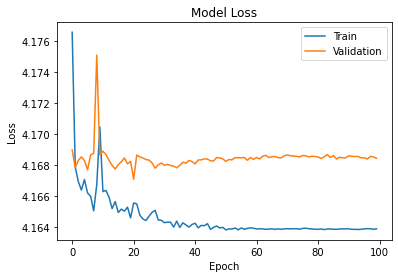

In [20]:
plot_loss(history)
plt.show()

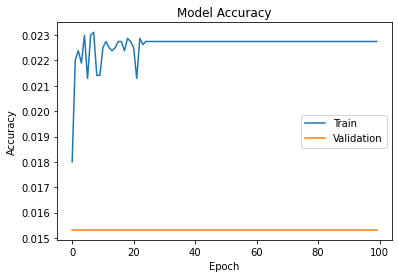

In [21]:
plot_acc(history)
plt.show()

In [22]:
predictions = model.predict(x_test)

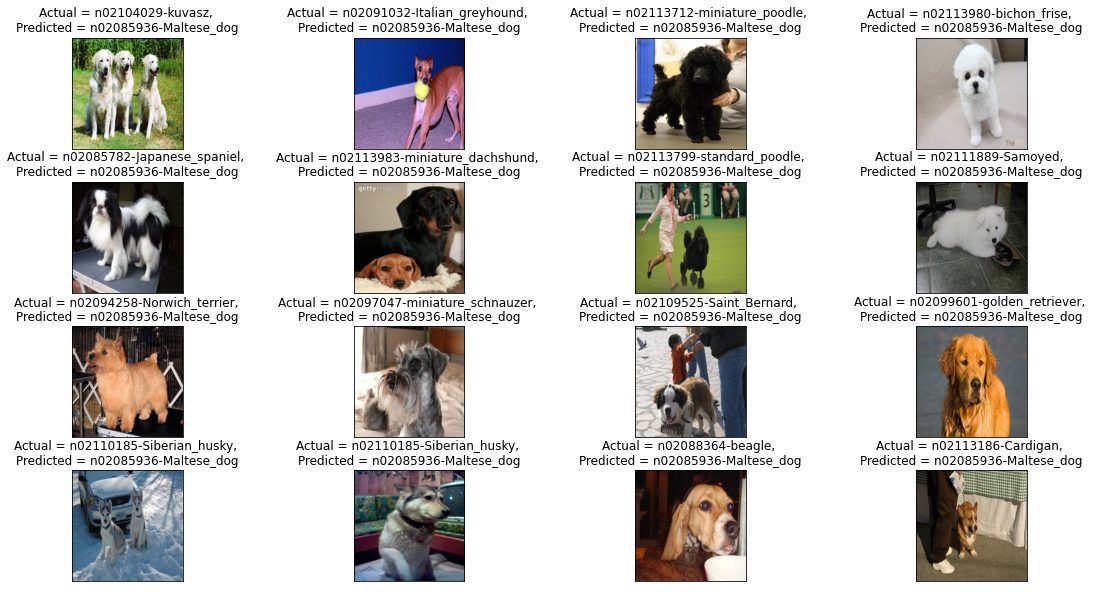

In [28]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(16):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(4, 4, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, \nPredicted = {}'.format(categories[np.argpartition(y_test[r[0]],-1)[-1:][0]] , categories[np.argpartition(predictions[2][r[0]],-1)[-1:][0]]))
    plt.xticks([]) , plt.yticks([])

plt.show()